# FoolboxをつかったAdversarial Examples

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import OrderedDict

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical

import sys
import os
sys.path.append('../libs')
import model_zoo as zoo
import measure

Using TensorFlow backend.


In [2]:
import foolbox
from foolbox.models import KerasModel
from foolbox.attacks import LBFGSAttack, FGSM, CarliniWagnerL2Attack, DeepFoolAttack, SaliencyMapAttack

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1) / 255.
x_test = x_test.reshape(-1, 28, 28, 1) / 255.

In [4]:
# 攻撃対象のCNNの保存先 or 読み込み先
model_path = Path("..", "model_dir")
model_path.mkdir(exist_ok=True)
model_path /= "target_cnn.h5"

# 学習済みのCNNがあればロード、なければ作成
if model_path.exists():
    model = load_model(str(model_path))
else:
    log_dir = Path('..', 'logs', 'cnn')
    model = zoo.CNN(input_shape=(28, 28, 1)) # MNIST用
    tb = TensorBoard(log_dir=str(log_dir))
    model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
    model.fit(x=x_train, y=y_train, epochs=5, validation_data=(x_test, y_test), callbacks=[tb])
    model.save(str(model_path))

Instructions for updating:
Colocations handled automatically by placer.


# ここから攻撃

In [5]:
# 攻撃対象のモデルをfmodelとしてラップ
fmodel = foolbox.models.TensorFlowModel.from_keras(model, bounds=(0, 1))
# 誤認識させることを評価基準とする
attack_criterion = foolbox.criteria.Misclassification()

# Adversarial Examplesの攻撃手法
fgsm = FGSM(fmodel, criterion=attack_criterion)
saliency = SaliencyMapAttack(fmodel, criterion=attack_criterion)
contrast = foolbox.attacks.ContrastReductionAttack(fmodel, criterion=attack_criterion)

attack_dict = OrderedDict((name, eval(name)) for name in ['fgsm', 'saliency', 'contrast'])

## idxの画像に対して上のセルで定義したattacks.[メソッド]を適用

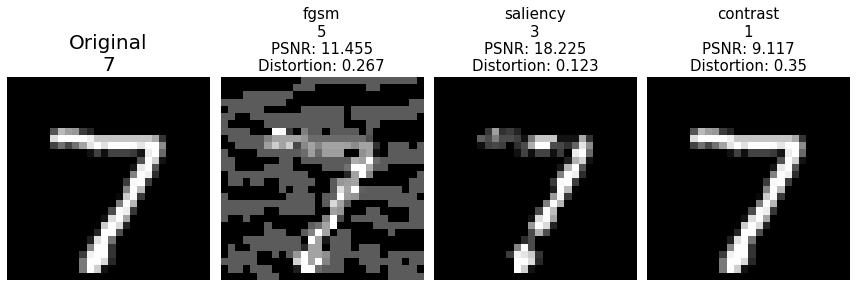

In [11]:
idx = 0
fig = plt.figure(figsize=(12, 48))

plt.subplot(1, 4, 1)
plt.imshow(np.squeeze(np.squeeze(x_test[idx])), cmap='gray')
plt.title(f"Original\n{np.argmax(model.predict(x_test[idx].reshape(-1, 28, 28, 1)))}", fontsize=20) # 通常画像の結果
plt.axis('off')
    
for i, (name, module) in enumerate(attack_dict.items()):
    x_adv = module(input_or_adv=x_test[idx], label=y_test[idx], unpack=False)
    plt.subplot(1, 4, i+1 + 1)
    plt.imshow(np.squeeze(x_adv.image), cmap='gray')
    p = measure.NpMetrics.psnr(x_test[idx], x_adv.image, 1)
    d = measure.NpMetrics.distortion(x_test[idx], x_adv.image)
    plt.title(f"{name}\n{np.argmax(model.predict(x_adv.image.reshape(-1, 28, 28, 1)))}\nPSNR: {p.round(3)}\nDistortion: {d.round(3)}", fontsize=15)
    plt.axis('off')
plt.tight_layout()